# 01 Sensitivity analysis of model parameters

## A. Imports

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from prettytable import PrettyTable

Add translation to the `sys.path`:

In [2]:
import sys
sys.path.append(r'../')
sys.path.append(r'../translation/')

In [3]:
import translation

## B. Ribosomes

In [4]:
filepath =  {150000: "../results/updated Shah transcriptome, full exome, no decay, updated initiation "
             "rates according to Shah, ribosomes factor 0.75_20211109_0347_150000_ribosomes_3600s.p",
             200000: "../results/updated Shah transcriptome, full exome, no decay, updated initiation "
             "rates according to Shah_20211109_0858_200000_ribosomes_3600s.p",
             250000: "../results/updated Shah transcriptome, full exome, no decay, updated initiation "
             "rates according to Shah, ribosomes factor 1.25_20211108_2333_250000_ribosomes_3600s.p"}

Load results from file:

In [5]:
results = {}

for nribo in filepath:
    print(filepath[nribo])
    with open(filepath[nribo], 'rb') as f:
        results[nribo] = pickle.load(f)

../results/updated Shah transcriptome, full exome, no decay, updated initiation rates according to Shah, ribosomes factor 0.75_20211109_0347_150000_ribosomes_3600s.p
../results/updated Shah transcriptome, full exome, no decay, updated initiation rates according to Shah_20211109_0858_200000_ribosomes_3600s.p
../results/updated Shah transcriptome, full exome, no decay, updated initiation rates according to Shah, ribosomes factor 1.25_20211108_2333_250000_ribosomes_3600s.p


In [6]:
results[150000].keys()

dict_keys(['proteome', 'peptide_bonds', 'transcriptome', 'timerange', 'timecourses', 'description', 'time_stamp', 'n_ribosomes', 'n_tRNA', 'duration'])

In [7]:
results[150000]['peptide_bonds']

1285720976

In [8]:
len(results[150000]['transcriptome'])

57508

Define protein names:

In [9]:
protnames = {}
blacklist = ['ribos._bound', 'ribos._free', 'tRNA_free', 'tRNA_bound', 'ATP', 'GTP', 'AMP', 'GDP', 'protein', 'peptide_bonds']

for nribo in results.keys():
    print(nribo)
    protnames[nribo] = results[nribo]['timecourses'].keys()
    for fragment in blacklist:
        protnames[nribo] = [name for name in protnames[nribo] if fragment not in name]

150000
200000
250000


### B.1 Protein speeds

Define protein speeds:

In [10]:
prot_speeds = {}

for nribo in results.keys():
    print(nribo)
    prot_speeds[nribo] = {}
    for prot in protnames[nribo]:
        start, stop = 599, len(results[nribo]['timecourses'][prot]) - 1  # 599 to exclude the "burn in" phase
        prot_speeds[nribo][prot] = (results[nribo]['timecourses'][prot][stop] - results[nribo]['timecourses'][prot][start]) / \
        (1.0 * results[nribo]['timerange'][stop] - results[nribo]['timerange'][start])
        if prot_speeds[nribo][prot] > 25: 
            print(prot, prot_speeds[nribo][prot])

150000
YKL060C 28.761064425770304
YLR044C 38.547899159663864
200000
YJL189W 27.007282913165263
YKL152C 25.215406162464983
YKL060C 31.57787114845938
YOL086C 25.554699645653297
YAL038W 27.388515406162462
YLR044C 42.53949579831932
250000
YJL189W 28.892156862745093
YLR110C 26.039495798319326
YKL152C 27.07899159663865
YKL060C 33.71708683473389
YOL086C 27.364248799002784
YCR012W 26.57394957983193
YAL038W 29.31428571428571
YLR044C 45.90504201680672


In [11]:
transcriptome_shah = pickle.load(open('../parameters/transcriptome_shah.p', 'rb'))
orf_genomic_dict = pickle.load(open("../parameters/orf_coding.p", 'rb'))

In [12]:
orf_lengths = {prot: len(orf_genomic_dict[prot]) for prot in orf_genomic_dict}

In [13]:
prot_per_transcript_speeds = {}

for nribo in results.keys():
    print(nribo)
    prot_per_transcript_speeds[nribo] = {}
    for prot in protnames[nribo]:
        start, stop = 599, len(results[nribo]['timecourses'][prot]) - 1  # 599 to exclude the "burn in" phase
        prot_per_transcript_speeds[nribo][prot] = (results[nribo]['timecourses'][prot][stop] - results[nribo]['timecourses'][prot][start]) / \
            transcriptome_shah[prot] / (1.0 * results[nribo]['timerange'][stop] - results[nribo]['timerange'][start])
        if prot_per_transcript_speeds[nribo][prot] > 0.05: 
            print(prot, prot_per_transcript_speeds[nribo][prot])

150000
YDR461W 0.053068500127323656
YLR388W 0.05006672826198542
200000
YDR461W 0.057431457431457424
YLR388W 0.054819833692639354
YDR224C 0.05267884931750478
YJL158C 0.05085200746965452
250000
YDR461W 0.06231219760631525
YJL189W 0.052340863881784584
YLR388W 0.05866660800445832
YDR224C 0.055404383975812536
YFL014W 0.050606909430438836
YJL158C 0.05416083099906628


In [14]:
def plot_speed_efficiency(prot_speeds, prot_per_transcript_speeds):
    plt.rcParams['figure.figsize'] = (12, 5)
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['axes.edgecolor'] = 'grey'

    fig = plt.figure()
    fig.subplots_adjust(wspace=0.35)

    ax = fig.add_subplot(121)
    n, bins, patches = ax.hist(prot_speeds.values(), 
                               bins = 10**np.linspace(np.log10(min(prot_speeds.values())+0.0001), 
                                                      np.log10(max(prot_speeds.values())), 25), 
                               edgecolor='white')
    ax.set_xscale("log")
    ax.set_xlim([min(prot_speeds.values())+0.0001, max(prot_speeds.values())])
    ax.set_xlabel('Translation speed [proteins/s]', fontsize=16)
    ax.set_ylabel('Protein count', fontsize=16)
    plt.setp(ax.get_xticklabels(), fontsize=16)
    plt.setp(ax.get_yticklabels(), fontsize=16)
    plt.text(0.0001, 670, "A", fontsize=16, weight="bold")

    ax = fig.add_subplot(122)
    n, bins, patches = ax.hist(prot_per_transcript_speeds.values(), 
                               bins = 10**np.linspace(np.log10(min(prot_per_transcript_speeds.values())+0.0001), 
                                                      np.log10(max(prot_per_transcript_speeds.values())), 32), 
                               edgecolor='white')
    ax.set_xscale("log")
    ax.set_xlim([min(prot_per_transcript_speeds.values())+0.002, max(prot_per_transcript_speeds.values())])
    ax.set_xlabel('Translation efficiency [proteins/transcript/s]', fontsize=16)
    ax.set_ylabel('Protein count', fontsize=16)
    plt.setp(ax.get_xticklabels(), fontsize=16)
    plt.setp(ax.get_yticklabels(), fontsize=16)
    plt.text(0.0009, 600, "B", fontsize=16, weight="bold")

    #plt.show()
    plt.savefig('../plots/translation_efficiencies.pdf', bbox_inches='tight') # TODO: fixed name is not nice

Five-number summary:

In [15]:
def fivenum(data):
    """Five-number summary."""
    return np.percentile(list(data), [0, 25, 50, 75, 100], interpolation='midpoint')

In [16]:
print("Protein speeds:")
t = PrettyTable(["Ribosomes", 'Min', '25%', 'Median', '75%', 'Max'])
for nribo in results.keys():
    t.add_row([nribo] + list(fivenum(prot_speeds[nribo].values())))
print(t)

Protein speeds:
+-----------+------------------------+----------------------+----------------------+---------------------+--------------------+
| Ribosomes |          Min           |         25%          |        Median        |         75%         |        Max         |
+-----------+------------------------+----------------------+----------------------+---------------------+--------------------+
|   150000  | 0.00028011204481792715 | 0.009523809523809523 | 0.02352974131290354  | 0.07282913165266106 | 38.547899159663864 |
|   200000  | 0.00028011204481792715 | 0.010364145658263303 | 0.026050420168067225 | 0.08123249299719887 | 42.53949579831932  |
|   250000  | 0.00028011204481792715 | 0.011204481792717085 | 0.028011204481792715 | 0.08641456582633052 | 45.90504201680672  |
+-----------+------------------------+----------------------+----------------------+---------------------+--------------------+


Protein speeds per transcript:
+-----------+------------------------+-----------------------+----------------------+----------------------+----------------------+
| Ribosomes |          Min           |          25%          |        Median        |         75%          |         Max          |
+-----------+------------------------+-----------------------+----------------------+----------------------+----------------------+
|   150000  | 8.670134720554888e-05  | 0.0050420168067226885 | 0.007563025210084033 | 0.011344537815126048 | 0.053068500127323656 |
|   200000  | 0.00010337468320661597 |  0.005602240896358543 | 0.008403361344537815 | 0.012476043048798466 | 0.057431457431457424 |
|   250000  | 0.00014005602240896358 |  0.006018723278785197 | 0.009041520967458305 | 0.013352007469654526 | 0.06231219760631525  |
+-----------+------------------------+-----------------------+----------------------+----------------------+----------------------+


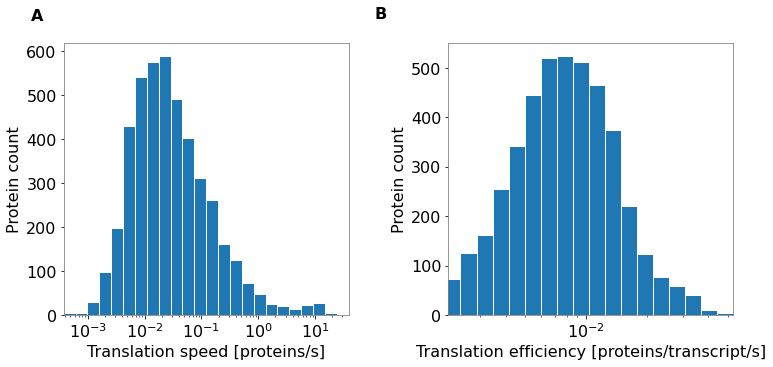

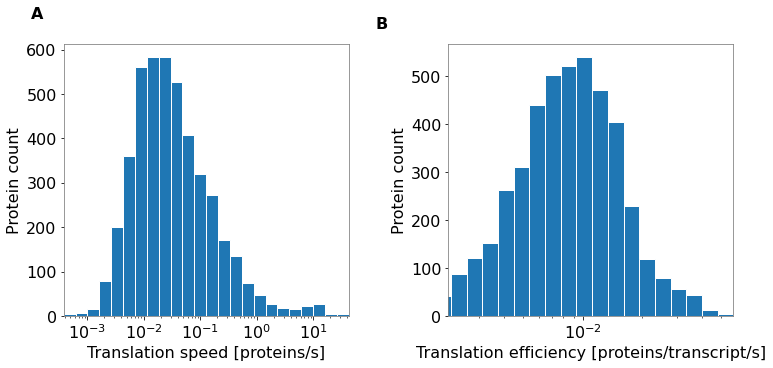

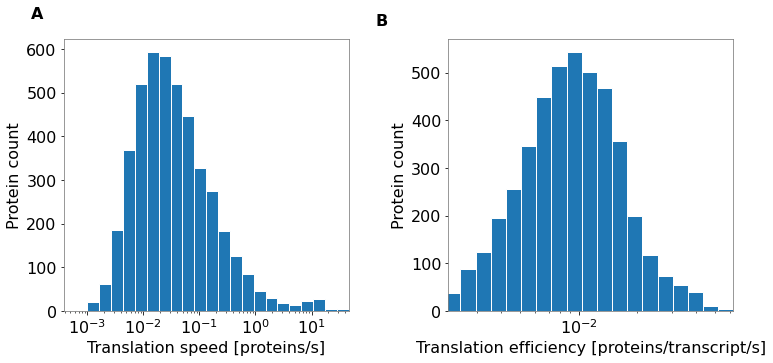

In [17]:
print("Protein speeds per transcript:")
t = PrettyTable(["Ribosomes", 'Min', '25%', 'Median', '75%', 'Max'])
for nribo in results.keys():
    t.add_row([nribo] + list(fivenum(prot_per_transcript_speeds[nribo].values())))
    plot_speed_efficiency(prot_speeds[nribo], prot_per_transcript_speeds[nribo])
print(t)

Calculation of elasticities w.r.t. ribosome count:

Elasticity down $\Delta \% X / \Delta \% n_{\mathrm{Ribo}}$:

In [18]:
delta_percent_prot_speed_median_down = (fivenum(prot_speeds[200000].values())[2] - 
                                                       fivenum(prot_speeds[150000].values())[2]) / fivenum(prot_speeds[200000].values())[2]
elasticity_prot_speed_median_down = delta_percent_prot_speed_median_down / 0.25
print(f"Elasticity downwards median of protein speed per transcript: {elasticity_prot_speed_median_down:.1%}")

Elasticity downwards median of protein speed per transcript: 38.7%


In [19]:
delta_percent_prot_per_transcript_speed_median_down = (fivenum(prot_per_transcript_speeds[200000].values())[2] - 
                                                       fivenum(prot_per_transcript_speeds[150000].values())[2]) / fivenum(prot_per_transcript_speeds[200000].values())[2]
elasticity_prot_per_transcript_speed_median_down = delta_percent_prot_per_transcript_speed_median_down / 0.25
print(f"Elasticity downwards median of protein speed per transcript: {elasticity_prot_per_transcript_speed_median_down:.1%}")

Elasticity downwards median of protein speed per transcript: 40.0%


Elasticity up $\Delta \% X / \Delta \% n_{\mathrm{Ribo}}$:

In [20]:
delta_percent_prot_speed_median_up = (fivenum(prot_speeds[250000].values())[2] - 
                                                       fivenum(prot_speeds[200000].values())[2]) / fivenum(prot_speeds[200000].values())[2]
elasticity_prot_speed_median_up = delta_percent_prot_speed_median_up / 0.25
print(f"Elasticity upwards median of protein speed per transcript: {elasticity_prot_speed_median_up:.1%}")

Elasticity upwards median of protein speed per transcript: 30.1%


In [21]:
delta_percent_prot_per_transcript_speed_median_up = (fivenum(prot_per_transcript_speeds[250000].values())[2] - 
                                                       fivenum(prot_per_transcript_speeds[200000].values())[2]) / fivenum(prot_per_transcript_speeds[200000].values())[2]
elasticity_prot_per_transcript_speed_median_up = delta_percent_prot_per_transcript_speed_median_up / 0.25
print(f"Elasticity upwards median of protein speed per transcript: {elasticity_prot_per_transcript_speed_median_up:.1%}")

Elasticity upwards median of protein speed per transcript: 30.4%


### B.2 Ribosome speeds

In [22]:
df1 = pd.DataFrame.from_dict(orf_lengths.items())
df1.columns = ['name', 'ORF length [nts]']

In [23]:
transcript_tic_toc = {}
transcript_tic_toc_averages = {}
transcript_df = {}
temp_df = {}
gene_tic_toc = {}
gene_tic_toc_df = {}
df = {}
ribo_speed_dict = {}

for nribo in results.keys():
    transcript_tic_toc[nribo] = {transcript.index: transcript.tic_toc for transcript in results[nribo]['transcriptome']}
    transcript_tic_toc_averages[nribo] = {index: np.mean([toc-tic for (tic, toc) in transcript_tic_toc[nribo][index]]) for index in transcript_tic_toc[nribo]}
    # transcript_df[nribo] = pd.DataFrame(transcript_tic_toc_averages[nribo].values(), index=transcript_tic_toc_averages[nribo].keys())
    transcript_df[nribo] = pd.DataFrame(pd.Series(transcript_tic_toc_averages[nribo]))
    transcript_df[nribo].columns = ['tic_toc']
    temp_df[nribo] = pd.DataFrame(pd.Series({transcript.index: transcript.geneID for transcript in results[nribo]['transcriptome']}))
    temp_df[nribo].columns = ['geneID']
    transcript_df[nribo] = pd.merge(transcript_df[nribo], temp_df[nribo], left_index=True, right_index=True, how='outer')
    gene_tic_toc[nribo] = transcript_df[nribo].groupby('geneID').mean().to_dict()['tic_toc']
    gene_tic_toc_df[nribo] = pd.DataFrame.from_dict(gene_tic_toc[nribo].items())
    gene_tic_toc_df[nribo].columns = ['name', 'tic toc [s]']
    df[nribo] = pd.merge(gene_tic_toc_df[nribo], df1, left_on='name', right_on='name', how='outer')
    ribo_speed_dict[nribo] = {geneID: orf_lengths[geneID] / 3.0 / gene_tic_toc[nribo][geneID] for geneID in gene_tic_toc[nribo]}

/home/mjs/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mjs/.local/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [24]:
def plot_time_finish_ribosome_speed(ribo_speed_dict, df):
    plt.rcParams['figure.figsize'] = (12, 5)
    plt.rcParams['axes.edgecolor'] = 'black'
    plt.rcParams['axes.labelcolor'] = 'black'
    plt.rcParams['xtick.color'] = 'black'
    plt.rcParams['ytick.color'] = 'black'
    plt.rcParams['grid.linestyle'] = '-.'
    plt.rcParams['grid.color'] = 'grey'
    #plt.rcParams['figure.facecolor'] = 'white'

    hfont = {'fontname':'FreeSans'}

    fig = plt.figure()
    fig.subplots_adjust(wspace=0.35)

    ax = fig.add_subplot(121, facecolor='white')
    ax.scatter(df['ORF length [nts]'], df['tic toc [s]'], alpha=0.8, color='navy', edgecolor='steelblue', linewidth=1)
    ax.set_xlabel('ORF length [nts]', fontsize=16, **hfont)
    ax.set_ylabel('Time to finish protein [s]', fontsize=16, **hfont)
    plt.setp(ax.get_xticklabels(), fontsize=16, **hfont)
    plt.setp(ax.get_yticklabels(), fontsize=16, **hfont)
    ax.set_yscale('log')
    ax.set_xscale('log')

    ax = fig.add_subplot(122, facecolor='white')
    plt.hist(ribo_speed_dict.values(), 
             bins=np.arange(min(ribo_speed_dict.values()), max(ribo_speed_dict.values()), 0.5), 
                               color='navy', edgecolor='steelblue')
    ax.set_xlabel('Ribosome speed [codons/s]', fontsize=16, **hfont)
    ax.set_ylabel('Frequency', fontsize=16, **hfont)
    plt.setp(plt.gca().get_xticklabels(), fontsize=16, **hfont)
    plt.setp(plt.gca().get_yticklabels(), fontsize=16, **hfont)
    
    #plt.show()
    #plt.savefig("ribosome_speeds.pdf")

150000
200000
250000


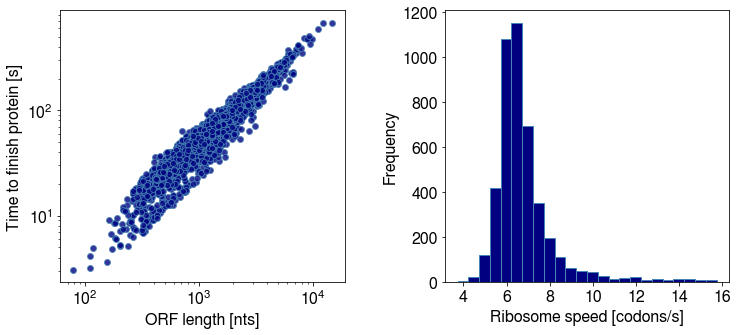

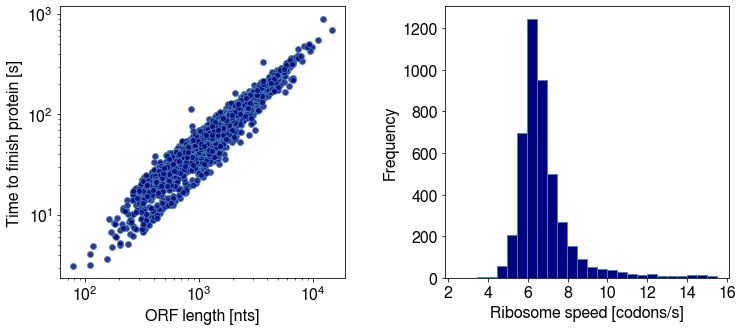

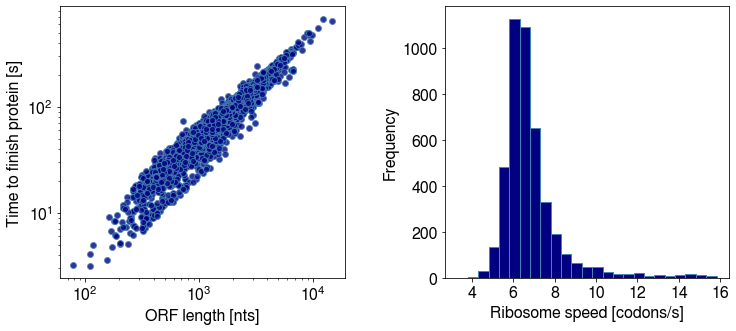

In [25]:
for nribo in results.keys():
    print(nribo)
    plot_time_finish_ribosome_speed(ribo_speed_dict[nribo], df[nribo])

Slopes/intercepts of time to finish vs. length plots:

In [28]:
for nribo in results.keys():
    print(nribo)
    Y = np.log(df[nribo]['tic toc [s]'])
    X = np.log(df[nribo]['ORF length [nts]'])
    X = sm.add_constant(X)

    model = sm.OLS(Y, X, missing='drop')
    res = model.fit()
    print(res.params)

150000
const              -3.056239
ORF length [nts]    1.008089
dtype: float64
200000
const              -3.055218
ORF length [nts]    1.007360
dtype: float64
250000
const              -3.042343
ORF length [nts]    1.005020
dtype: float64


Almost identical.

Average ribosome speeds:

In [48]:
for nribo in results.keys():
    print(nribo)
    speeds = np.array(list(ribo_speed_dict[nribo].values()))
    print(np.nanmean(speeds))

150000
6.80906155936347
200000
6.83991307581582
250000
6.866220097778142


TODO: elasticities